# Data sourcing and preprocessing

As with any other Machine Learning application, the first step is to get and prepare the data for our models.
This notebook will focus in doing precisely this, explaining step by step the data obtained and using graphs to
 visualize these features. At the end of the notebook, we prepare clean data sets,
 which will be stored in the `data/` folder.


### What will we do?

Our goal will be to obtain and process the data, specifically:
- Use Quandl and yfinance to **source stock market, currencies and Bitcoin fundamentals.**
- **Calculate technical analysis indicators**, such as simple moving averages, relative strength index (RSI),
stochastic RSI, cumulated standard deviation and distance to prices.
- **Label data** necessary to provide trading signal predictions later. These labels were selected according to the
historical distribution of daily Bitcoin returns.
- **Create different plots, histograms and heatmaps** to have an initial feeling of how the features look like.
- **Join and clean up the datasets**
- **Store data** with and without transformations to feed in the relevant Azure service with appropiate data.

## Importing dependencies and utility functions

As described in our project proposal, we will first use historical data from financial data as our data inputs.
For this, we are going to use `yfinance` library, that scrapes this data from Yahoo Finance,
returning it as a pandas dataframe, which will facilitate most of this work, and also we'll use `quandl`.

However, since the tickers mostly have special signs and we want to create an object for each ticker historical data,
I'll first get the data and clear the name to get an appropiate object.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import yfinance as yf

# import cufflinks as cf
from matplotlib import pyplot as plt

from data_utils.transformations import lower_clean_name, change_name, min_max_scaler, back_min_max, \
    standardizer, back_standardizer, get_log_cumulative

from data_utils.settings import ma_values, rsi_values, ticker_list

## Data Sourcing

In [2]:
signs = ['=','^','-','.']
labels = [lower_clean_name(word,signs) for word in ticker_list]
changed_labels = [change_name(x) for x in labels]

for x in range(len(labels)):
    print(labels[x] +' = '+changed_labels[x])

ticker_concat = " ".join(ticker_list)
ohlcv = yf.download(ticker_concat, start="2008-01-01", threads=False)
tickers = yf.download(ticker_concat, start="2008-01-01", group_by='tickers')

gspc = spy
ixic = nasdaq
gcf = gold
sif = silver
clf = crude oil
tnx = rates
btcusd = btc
n225 = nikkei
ftse = ftse
eurusdx = euro
000001ss = shangai
hsi = hsi
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  12 of 12 completed


In [3]:
ohlcv.tail()

Adj Close                                                  \
              000001.SS       BTC-USD       CL=F  EURUSD=X         GC=F   
Date                                                                      
2022-02-14  3428.879883  42586.917969  95.459999  1.136506  1868.000000   
2022-02-15  3446.090088  44575.203125  92.070000  1.130633  1854.800049   
2022-02-16  3465.830078  43961.859375  93.660004  1.135680  1870.199951   
2022-02-17  3468.040039  40538.011719  91.760002  1.137527  1900.699951   
2022-02-18  3490.757324  39942.332031  91.029999  1.133787  1897.099976   

                                                                             \
                 SI=F        ^FTSE        ^GSPC          ^HSI         ^IXIC   
Date                                                                          
2022-02-14  23.844999  7531.600098  4401.669922  24556.570312  13790.919922   
2022-02-15  23.337999  7608.899902  4471.069824  24355.710938  14139.759766   
2022-02-16  23.601000  7603.799805  4475.009766  24718.900391  14124.089844   
2022-02-17  23.874001  7537.399902  4380.259766  24792.769531  13716.719727   
2022-02-18  24.004999  7538.270020  4367.870117  24327.710938  13609.864258   

                                       Close                           \
                   ^N225   ^TNX    000001.SS       BTC-USD       CL=F   
Date                                                                    
2022-02-14  27079.589844  1.996  3428.879883  42586.917969  95.459999   
2022-02-15  26865.189453  2.045  3446.090088  44575.203125  92.070000   
2022-02-16  27460.400391  2.047  3465.830078  43961.859375  93.660004   
2022-02-17  27232.869141  1.972  3468.040039  40538.011719  91.760002   
2022-02-18  27122.070312  1.937  3490.757324  39942.332031  91.029999   

                                                                        \
            EURUSD=X         GC=F       SI=F        ^FTSE        ^GSPC   
Date                                                                     
2022-02-14  1.136506  1868.000000  23.844999  7531.600098  4401.669922   
2022-02-15  1.130633  1854.800049  23.337999  7608.899902  4471.069824   
2022-02-16  1.135680  1870.199951  23.601000  7603.799805  4475.009766   
2022-02-17  1.137527  1900.699951  23.874001  7537.399902  4380.259766   
2022-02-18  1.133787  1897.099976  24.004999  7538.270020  4367.870117   

                                                                    High  \
                    ^HSI         ^IXIC         ^N225   ^TNX    000001.SS   
Date                                                                       
2022-02-14  24556.570312  13790.919922  27079.589844  1.996  3457.260010   
2022-02-15  24355.710938  14139.759766  26865.189453  2.045  3447.489990   
2022-02-16  24718.900391  14124.089844  27460.400391  2.047  3475.060059   
2022-02-17  24792.769531  13716.719727  27232.869141  1.972  3480.969971   
2022-02-18  24327.710938  13609.864258  27122.070312  1.937  3490.757324   

                                                                       \
                 BTC-USD       CL=F  EURUSD=X         GC=F       SI=F   
Date                                                                    
2022-02-14  42775.777344  95.820000  1.136893  1870.599976  23.915001   
2022-02-15  44667.218750  95.169998  1.136880  1879.699951  23.337999   
2022-02-16  44578.277344  95.010002  1.139315  1870.199951  23.601000   
2022-02-17  44132.972656  93.360001  1.138693  1900.699951  23.874001   
2022-02-18  40922.371094  91.870003  1.138174  1905.000000  24.115000   

                                                                  \
                  ^FTSE        ^GSPC          ^HSI         ^IXIC   
Date                                                               
2022-02-14  7661.000000  4426.220215  24733.109375  13921.709961   
2022-02-15  7608.899902  4472.770020  24570.089844  14142.490234   
2022-02-16  7630.700195  4489.549805  24728.929688  14163.730469   


In [4]:
tickers.head()

000001.SS                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2007-12-31          NaN          NaN          NaN          NaN          NaN   
2008-01-01          NaN          NaN          NaN          NaN          NaN   
2008-01-02  5265.000000  5295.016113  5201.892090  5272.813965  5272.813965   
2008-01-03  5269.800781  5321.457031  5211.045898  5319.860840  5319.860840   
2008-01-04  5328.411133  5372.460938  5318.460938  5361.574219  5361.574219   

                           ^FTSE                                         \
             Volume         Open         High          Low        Close   
Date                                                                      
2007-12-31      NaN  6476.899902  6480.200195  6432.799805  6456.899902   
2008-01-01      NaN          NaN          NaN          NaN          NaN   
2008-01-02  76600.0  6456.899902  6512.299805  6402.600098  6416.700195   
2008-01-03  98600.0  6416.700195  6487.799805  6394.600098  6479.399902   
2008-01-04  80800.0  6479.399902  6534.700195  6333.200195  6348.500000   

                                               ^HSI                \
              Adj Close        Volume          Open          High   
Date                                                                
2007-12-31  6456.899902  1.939165e+08           NaN           NaN   
2008-01-01          NaN           NaN           NaN           NaN   
2008-01-02  6416.700195  6.740733e+08  27632.199219  27853.599609   
2008-01-03  6479.399902  9.324117e+08  27050.029297  27223.710938   
2008-01-04  6348.500000  1.182498e+09  27004.339844  27596.859375   

                                                                    \
                     Low         Close     Adj Close        Volume   
Date                                                                 
2007-12-31           NaN           NaN           NaN           NaN   
2008-01-01           NaN           NaN           NaN           NaN   
2008-01-02  27299.449219  27560.519531  27560.519531  1.232143e+09   
2008-01-03  26864.130859  26887.279297  26887.279297  2.442744e+09   
2008-01-04  26994.849609  27519.689453  27519.689453  2.375522e+09   

                  ^GSPC                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2007-12-31  1475.250000  1475.829956  1465.130005  1468.359985  1468.359985   
2008-01-01          NaN          NaN          NaN          NaN          NaN   
2008-01-02  1467.969971  1471.770020  1442.069946  1447.160034  1447.160034   
2008-01-03  1447.550049  1456.800049  1443.729980  1447.160034  1447.160034   
2008-01-04  1444.010010  1444.010010  1411.189941  1411.630005  1411.630005   

                          EURUSD=X                                          \
                  Volume      Open      High       Low     Close Adj Close   
Date                                                                         
2007-12-31  2.440880e+09  1.473709  1.474992  1.457301  1.460110  1.460110   
2008-01-01           NaN  1.460110  1.462994  1.458194  1.462010  1.462010   
2008-01-02  3.452650e+09  1.462309  1.474296  1.460110  1.471692  1.471692   
2008-01-03  3.429500e+09  1.471692  1.477891  1.469400  1.474491  1.474491   
2008-01-04  4.166000e+09  1.474709  1.481811  1.469896  1.475492  1.475492   

                         ^IXIC                                         \
           Volume         Open         High          Low        Close   
Date                                                                    
2007-12-31    0.0  2663.780029  2668.610107  2646.090088  2652.280029   
2008-01-01    0.0          NaN          NaN          NaN          NaN   
2008-01-02    0.0  2653.909912  2661.500000

In [5]:
# Renaming columns to changed labels
for x in [ohlcv, tickers]:
    x.rename(columns = lambda x: change_name(lower_clean_name(x,signs)), inplace=True)

open = ohlcv['open'].fillna(method='ffill')
high = ohlcv['high'].fillna(method='ffill')
low = ohlcv['low'].fillna(method='ffill')
close = ohlcv['close'].fillna(method='ffill')
volume = ohlcv['volume'].fillna(method='ffill')

In [6]:
# ohlcv.columns

### Making prices comparable:
### Returns and cumulative returns

To make stock prices comparable, we first need to bring all of them into the same base.
For this, we will use the `daily returns` of holding this stock. This way, instead of comparing stocks
with different prices (for example, Nikkei starting at 10k USD vs FTSE at 5k USD) we will bring all of them
 to the base of one at the start of the timeframe and record their daily increase or decrease in % to that base.

<AxesSubplot:title={'center':'Returns, excluding BTC [$]'}, xlabel='Date'>

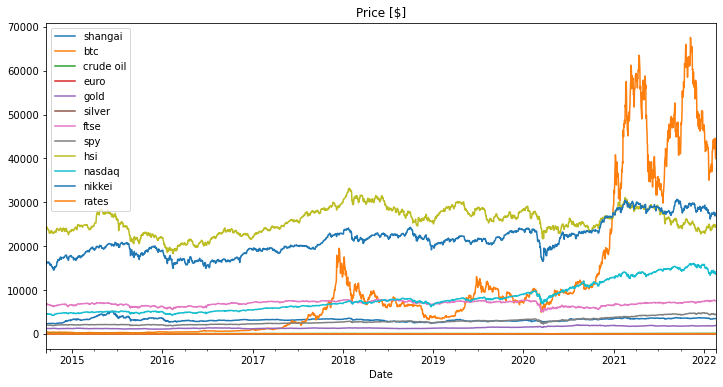

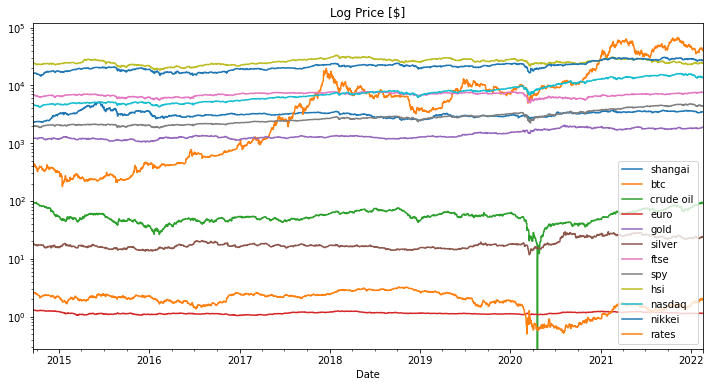

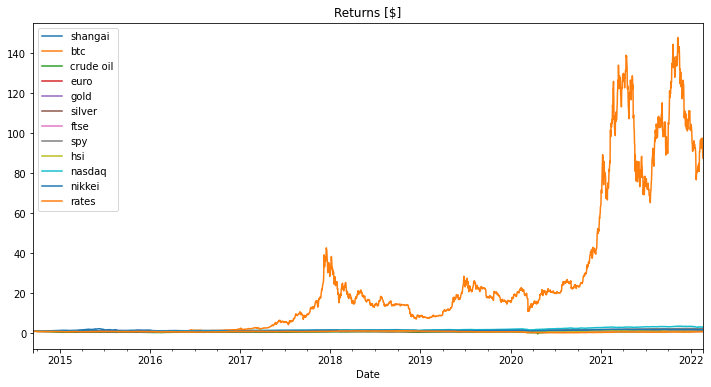

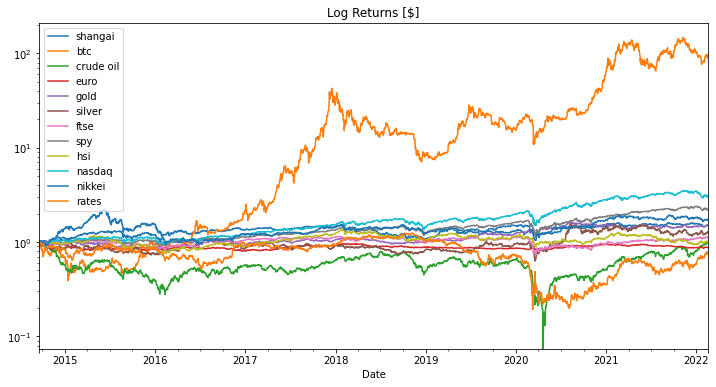

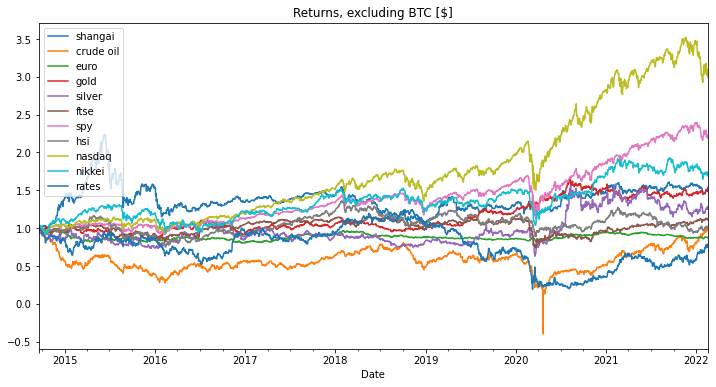

In [7]:
close = close[close.btc.notnull()]
returns = close.pct_change(1)
cumulative = (1 + returns).cumprod()

# For the above, it makes sense to take the logarithm
log_cumulative = np.log(cumulative)

close.plot(figsize=(12,6),label='Price', title='Price [$]')
close.plot(figsize=(12,6),label='Price (log scale)', logy=True, title='Log Price [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns', title='Returns [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns (log)', logy=True, title='Log Returns [$]')

cumulative.loc[:,cumulative.columns != 'btc'].plot(
    figsize=(12,6), label='Cumulative Returns', title='Returns, excluding BTC [$]')

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>],
       [<AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>],
       [<AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>]], dtype=object)

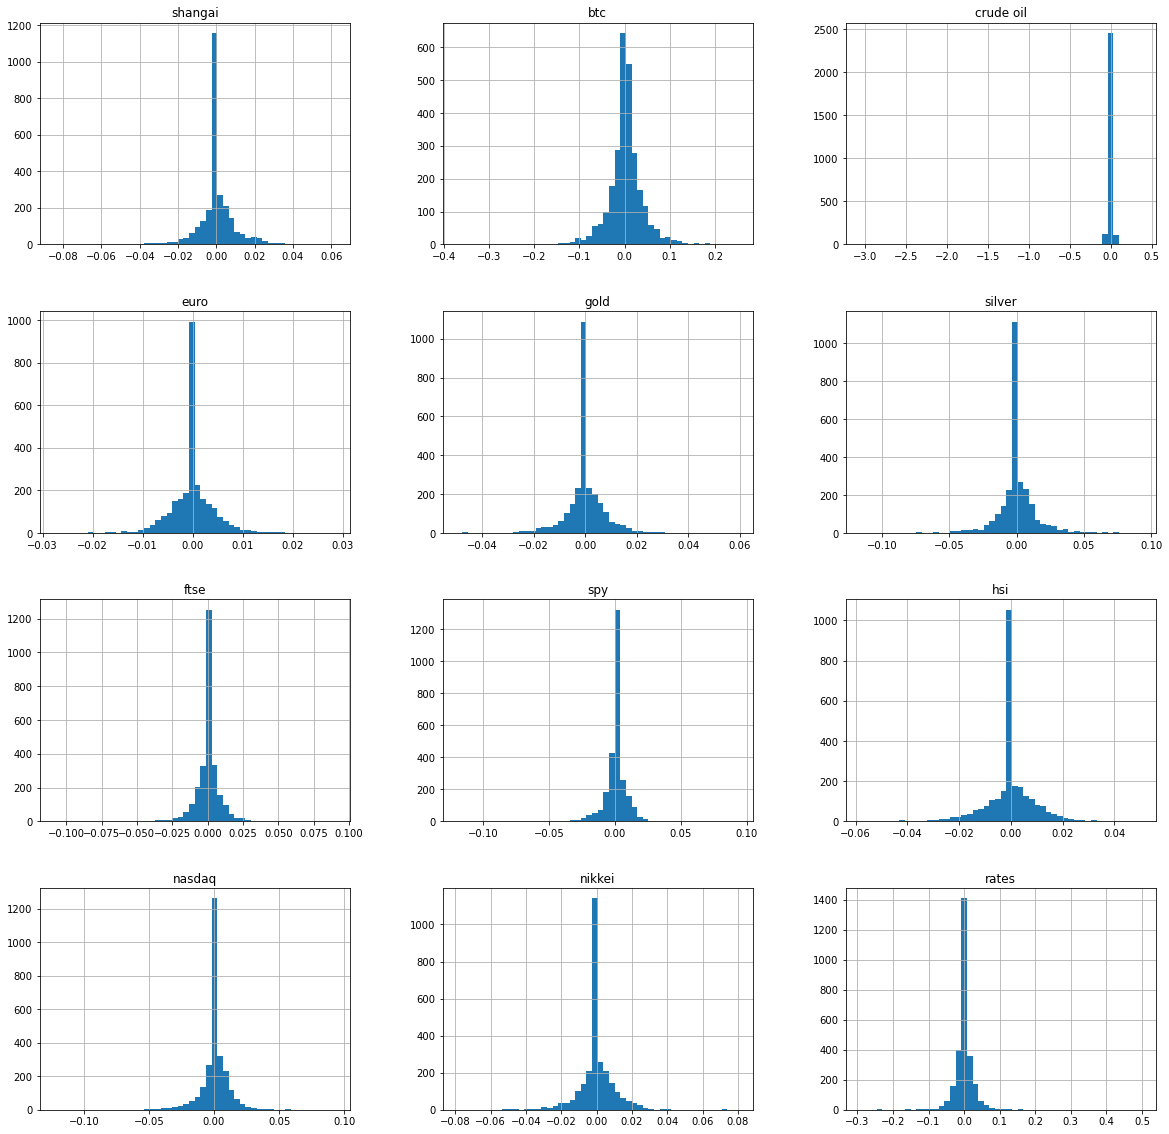

In [8]:
returns.hist(bins=50, figsize=(20,20))

As returns have a normal distribution, log normality will be possible with closing prices, but we will dive deeper
 into the dopic further ahead.

## Technical Indicator functions
Now we will calculate several indicators typically used in technical analysis of stock prices,
such as simple moving averages, the (stochastic) relative strength index and other statistical measures s.a.
the expanding standard deviation of Bitcoin price.

In [9]:
ta = tickers.btc

from data_utils.technical_analysis import transform_std, transform_ma, transform_rsi

### TODO for future improvement:
### Use vectorized functions for more speed.
ta = transform_std(transform_rsi(transform_ma(ta, ma_values[0], ma_values[1], ma_values[2])))
ta.tail()

/Users/renerivero/gitrepos/azure-ml/capstone/data_utils/technical_analysis.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA'+str(ma1)] = round(data['close'].rolling(ma1).mean(),0)
/Users/renerivero/gitrepos/azure-ml/capstone/data_utils/technical_analysis.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA'+str(ma2)] = round(data['close'].rolling(ma2).mean(),0)
/Users/renerivero/gitrepos/azure-ml/capstone/data_utils/technical_analysis.py:17: SettingWithCopyWarning: 
A value is trying t

,open,high,low,close,adj close,volume,MA4,MA50,MA80,change,cum_change,k,d,num,div,rs,RSI,RSImin,RSImax,stochRSI,smoothK,smoothD,K1,D1,btc_std_dev,btc_mean,std_dif
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-14,42157.398438,42775.777344,41681.957031,42586.917969,42586.917969,2.082778e+10,42359.0,41924.0,45151.0,0.009228,93.119944,0.009228,0.000000,0.009701,0.006368,1.523302,60.369397,36.668575,79.116099,55.835581,51.07,53.93,50.10,62.74,16071.463998,11267.558320,26515.453971
2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125,44575.203125,2.272166e+10,42901.0,41803.0,45023.0,0.046688,97.467500,0.046688,0.000000,0.014633,0.005519,2.651158,72.611430,36.668575,79.116099,84.675974,62.87,54.68,51.07,53.93,16081.234327,11279.853501,28493.968798
2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375,43961.859375,1.979255e+10,43330.0,41730.0,44857.0,-0.013760,96.126371,0.000000,0.013760,0.012682,0.006618,1.916215,65.708974,39.321819,79.116099,66.308915,68.94,60.96,62.87,54.68,16090.518123,11291.913281,27871.341252
2022-02-17,43937.070312,44132.972656,40249.371094,40538.011719,40538.011719,2.624666e+10,42915.0,41612.0,44641.0,-0.077882,88.639835,0.000000,0.077882,0.010991,0.016120,0.681810,40.540267,40.540267,79.116099,0.000000,50.33,60.71,68.94,60.96,16097.352010,11302.701219,24440.659709
2022-02-18,40475.714844,40922.371094,39810.578125,39920.164062,39920.164062,2.767991e+10,42249.0,41467.0,44428.0,-0.015241,87.288858,0.000000,0.015241,0.009525,0.016003,0.595229,37.313069,37.313069,79.116099,0.000000,22.10,47.12,50.33,60.71,16103.761521,11313.253381,23816.402542


In [10]:
# selection of technical indicators to feed the model
ta = ta[['open', 'high', 'low', 'close',
           f'MA{ma_values[0]}',f'MA{ma_values[1]}', f'MA{ma_values[2]}',
           'stochRSI', 'RSI','btc_std_dev','std_dif']].fillna(method='bfill')

### Exploring volume data

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>],
       [<AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>],
       [<AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>]], dtype=object)

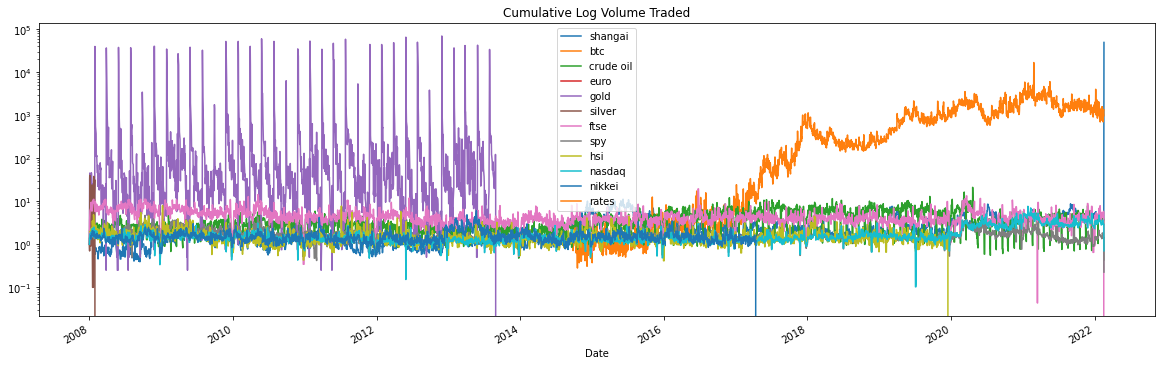

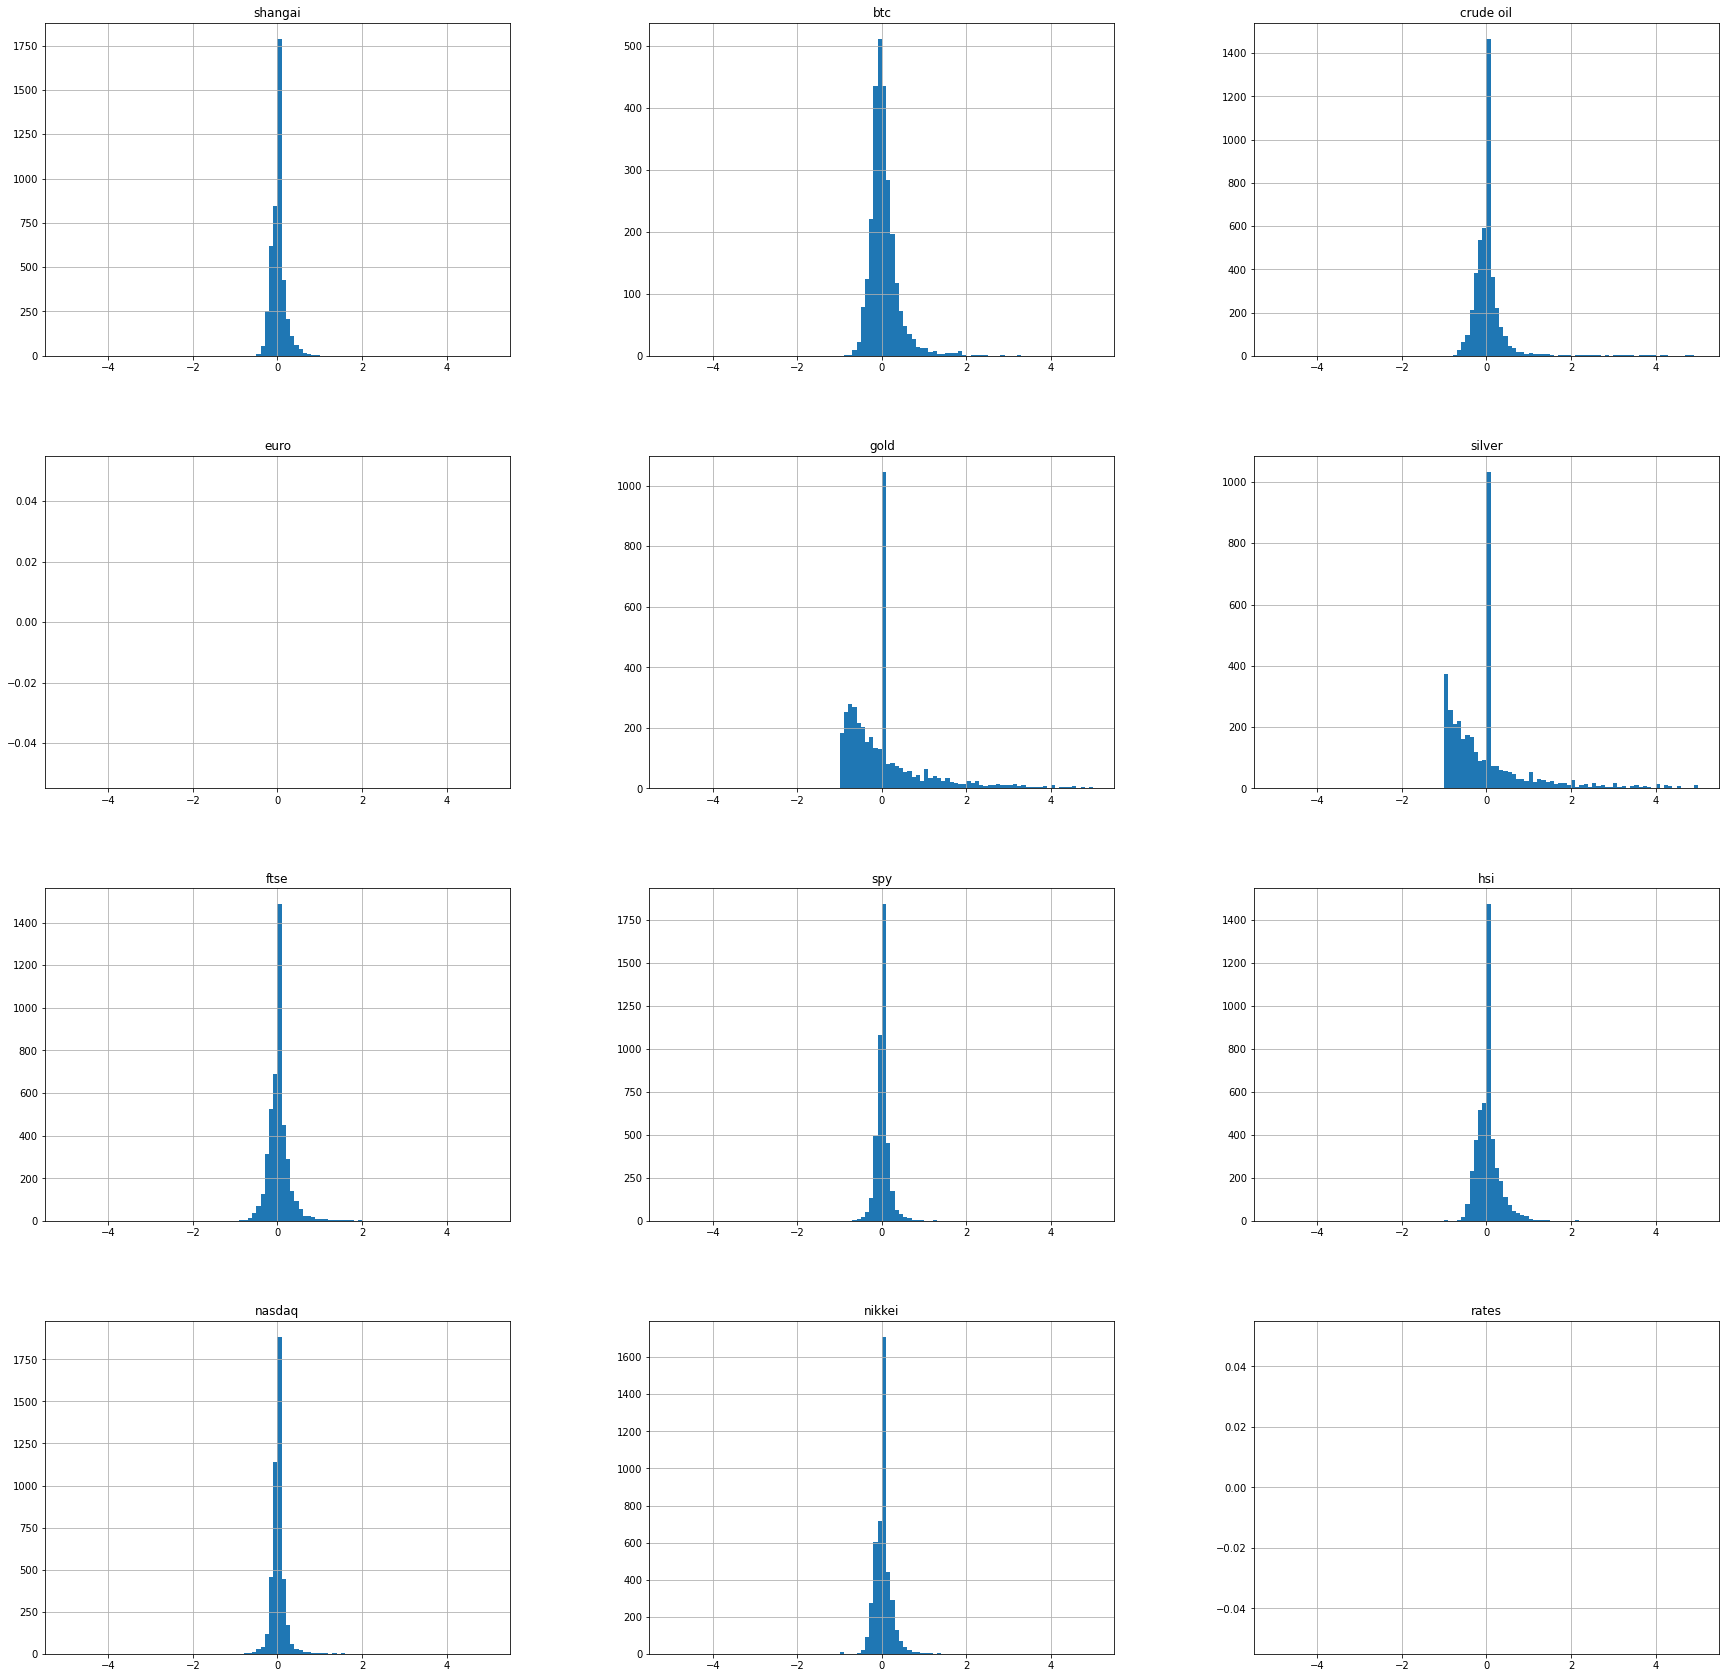

In [11]:
# volume.plot(logy=True, figsize=(20,6))
v_returns = volume.pct_change(1)
v_cumulative = (1+v_returns).cumprod()
v_cumulative.plot(logy=True, figsize=(20,6), title="Cumulative Log Volume Traded")
v_returns.hist(bins=100, figsize=(30,30), range=[-5, 5])

Ok volume data seems really interesting. However, gold and silver are skewed.
We also lack complete data of M2 money supply 'volume(?)' from 2014 onwards.

For the purpose of this capstone project, we will avoid including rates and the EUR/USD pair.

In [12]:
volume.drop(columns=['rates', 'euro'], inplace=True)
volume.columns

Index(['shangai', 'btc', 'crude oil', 'gold', 'silver', 'ftse', 'spy', 'hsi',
       'nasdaq', 'nikkei'],
      dtype='object')

In [13]:
volume.rename(columns = lambda x: "vol_" + x, inplace=True)
# volume.tail()

In [14]:
volume.describe()

,vol_shangai,vol_btc,vol_crude oil,vol_gold,vol_silver,vol_ftse,vol_spy,vol_hsi,vol_nasdaq,vol_nikkei
count,4.462000e+03,2.712000e+03,4.464000e+03,4464.000000,4464.000000,4.464000e+03,4.464000e+03,4.462000e+03,4.464000e+03,4.460000e+03
mean,1.032376e+06,1.470344e+10,4.145930e+05,5735.811156,1787.250224,8.571722e+08,3.990503e+09,1.892737e+09,2.446021e+09,1.215694e+08
std,5.606452e+07,2.002030e+10,2.121774e+05,30265.948812,9852.535833,3.380684e+08,1.174808e+09,7.449189e+08,1.170034e+09,5.415326e+07
min,3.040000e+04,5.914570e+06,4.693800e+04,0.000000,0.000000,0.000000e+00,5.516201e+08,0.000000e+00,1.494100e+08,0.000000e+00
25%,1.026000e+05,7.984830e+07,2.598610e+05,41.000000,8.000000,6.586728e+08,3.275038e+09,1.421597e+09,1.792472e+09,7.870000e+07
50%,1.551500e+05,5.093877e+09,3.619070e+05,141.000000,42.000000,7.868615e+08,3.709360e+09,1.739555e+09,2.034060e+09,1.178000e+08
75%,2.490250e+05,2.458943e+10,5.465388e+05,474.000000,152.000000,9.736458e+08,4.436285e+09,2.172185e+09,2.490730e+09,1.498000e+08
max,3.745193e+09,3.509679e+11,2.288230e+06,386334.000000,170297.000000,3.761301e+09,1.145623e+10,9.799120e+09,1.110216e+10,5.952000e+08


The problem with using volume data, seems that it is that not all instruments have it available,
plus we are not sure whether this is on the same measure value (USD). For this we will only take BTC.

### Fundamental Bitcoin data

Fundamental Bitcoin's blockchain data will also be included, such as hashrate, mining difficulty,
(daily) number of transactions and cost per transaction.

In [15]:
import quandl
import os

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

quandl_key = os.getenv("QUANDLKEY")
quandl.ApiConfig.api_key = quandl_key # (insert if available, else there is a ratelimit)

In [16]:
# print('This is your key!', quandl_key)

In [17]:

# btc mining is an interesting source, but free data has not the same quality ;)

# btcmining = quandl.get('BITCOINWATCH/MINING') # total btc and marketcap, bad quality data
# btcmining.fillna(method='ffill').plot(legend=None, logy=True)

btc_hrate = quandl.get('BCHAIN/HRATE') # hashrate
btc_diff = quandl.get('BCHAIN/DIFF') # difficulty
btc_ntrat = quandl.get('BCHAIN/NTRAT') # number of transactions
btc_cptra = quandl.get('BCHAIN/CPTRA') # cost per transaction


# m2 = quandl.get("FED/M2_N_WM") # unfortunately M2 money supply free data does not meet quality standards
# m2.rename({"Value":"M2"})

# fundamentals.fillna(method='ffill')

### Joining the data into a single DataFrame

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-14,3428.879883,42586.917969,95.459999,1.136506,1868.000000,23.844999,7531.600098,4401.669922,24556.570312,13790.919922,27079.589844,1.996,42157.398438,42775.777344,41681.957031,42586.917969,42359.0,41924.0,45151.0,55.835581,60.369397,16071.463998,26515.453971,2.082778e+10,2.029994e+08,2.669053e+13,710422684.0,164.948879
2022-02-15,3446.090088,44575.203125,92.070000,1.130633,1854.800049,23.337999,7608.899902,4471.069824,24355.710938,14139.759766,26865.189453,2.045,42586.464844,44667.218750,42491.035156,44575.203125,42901.0,41803.0,45023.0,84.675974,72.611430,16081.234327,28493.968798,2.272166e+10,2.321888e+08,2.669053e+13,710669547.0,177.371895
2022-02-16,3465.830078,43961.859375,93.660004,1.135680,1870.199951,23.601000,7603.799805,4475.009766,24718.900391,14124.089844,27460.400391,2.047,44578.277344,44578.277344,43456.691406,43961.859375,43330.0,41730.0,44857.0,66.308915,65.708974,16090.518123,27871.341252,1.979255e+10,2.069797e+08,2.669053e+13,710943183.0,161.787316
2022-02-17,3468.040039,40538.011719,91.760002,1.137527,1900.699951,23.874001,7537.399902,4380.259766,24792.769531,13716.719727,27232.869141,1.972,43937.070312,44132.972656,40249.371094,40538.011719,42915.0,41612.0,44641.0,0.000000,40.540267,16097.352010,24440.659709,2.624666e+10,2.132565e+08,2.732477e+13,711209926.0,166.350356
2022-02-18,3490.757324,39942.332031,91.029999,1.133787,1897.099976,24.004999,7538.270020,4367.870117,24327.710938,13609.864258,27122.070312,1.937,40475.714844,40922.371094,39810.578125,39920.164062,42249.0,41467.0,44428.0,0.000000,37.313069,16103.761521,23816.402542,2.767100e+10,NaN,NaN,NaN,NaN


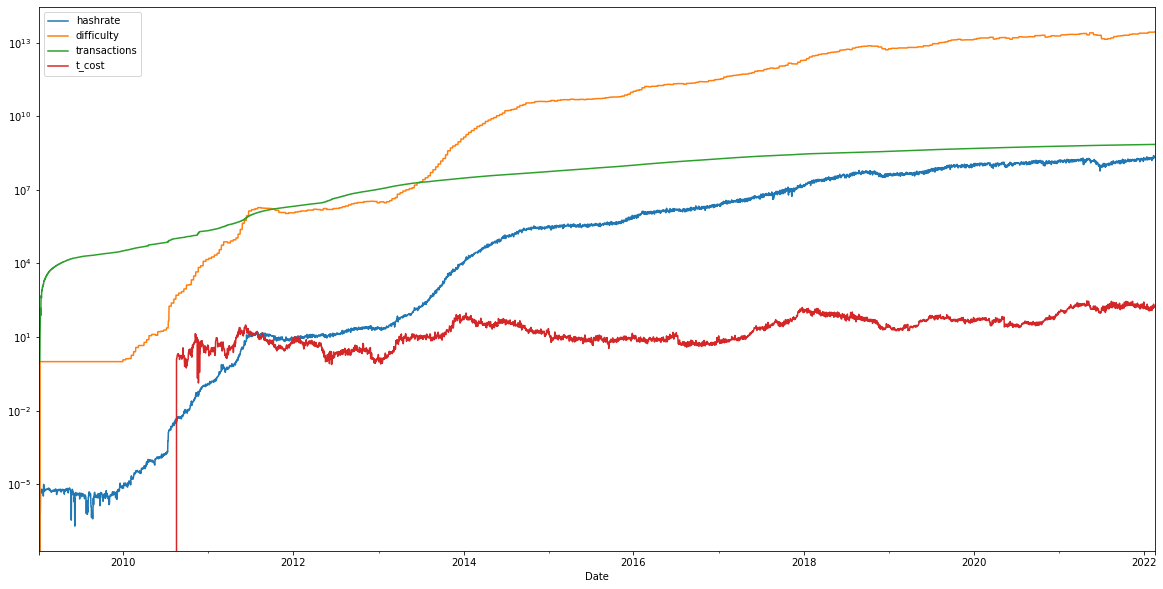

In [18]:
df = pd.concat([close, ta], axis=1)
df = pd.concat([df, volume['vol_btc']], axis=1)

fundamentals = pd.concat([btc_hrate, btc_diff, btc_ntrat, btc_cptra], axis=1)
fundamentals.columns = ['hashrate','difficulty','transactions','t_cost'] #, 'm2']
fundamentals.plot(figsize=(20,10), logy=True)
df = pd.concat([df, fundamentals], axis=1)
# df.rename(columns={'btc':'btc_cumulative'}, inplace=True)

df.tail()

## Labelling buy, sell and no-trade signals
Following our objective, we will need to predict whether prices are going to go up or down.
For this, the condition for the labels will be that if price goes up by more than a certain confidence level it's a buy,
 down a certain confidence level or less a sell, and values in between labelled as no-trade zone.

We will need to shift by one this values to become the predicted labels of our trained model.

In [19]:
returns.btc.describe()

count    2711.000000
mean        0.002412
std         0.038842
min        -0.371695
25%        -0.013147
50%         0.001993
75%         0.018255
max         0.252472
Name: btc, dtype: float64

Given the confidence intervals above, I will take the top 75% interval as buy label (1),
the lowest 25% for the sell label (2), and the values in between as no-trade (0).
The objective of the classification problem will be to **predict the next day's label to give a trading signal**.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,
          1.,   2.,   0.,   2.,   1.,   4.,   2.,   1.,   7.,   7.,  13.,
          5.,   9.,   9.,  16.,  18.,  39.,  30.,  33.,  45.,  55.,  78.,
         99., 124., 164., 282., 361., 308., 240., 149., 128.,  92.,  74.,
         67.,  51.,  35.,  24.,  24.,  22.,  13.,   8.,   7.,  16.,   8.,
          7.,   7.,   3.,   3.,   1.,   0.,   2.,   3.,   0.,   0.,   1.,
          2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([-0.37169539, -0.36545371, -0.35921204, -0.35297037, -0.3467287 ,
        -0.34048703, -0.33424536, -0.32800369, -0.32176202, -0.31552035,
        -0.30927868, -0.30303701, -0.29679534, -0.29055367, -0.28431199,
        -0.27807032, -0.27182865, -0.26558698, -0.25934531, -0.25310364,
        -0.24686197, -0.24

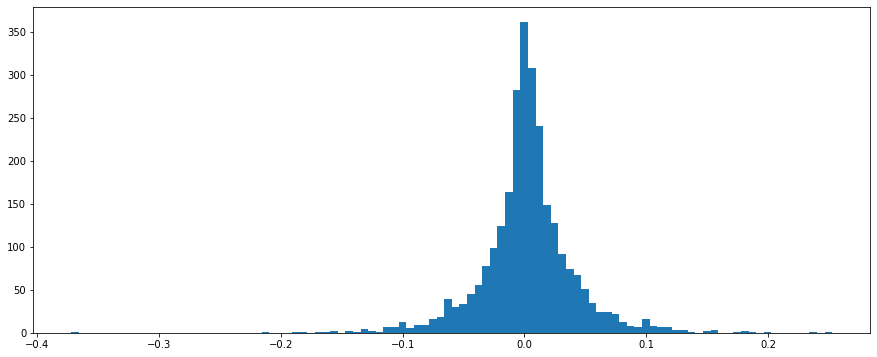

In [20]:
plt.figure(figsize = (15,6))
plt.hist(returns.btc, bins=100)

In [21]:
print(log_cumulative.columns)
# log_cumulative.tail()

Index(['shangai', 'btc', 'crude oil', 'euro', 'gold', 'silver', 'ftse', 'spy',
       'hsi', 'nasdaq', 'nikkei', 'rates'],
      dtype='object')


### Creating labels

In [22]:
labels = pd.DataFrame(returns.btc)
labels['y_returns'] = returns.btc
labels.drop(columns=['btc'], inplace=True)
labels['y_close'] = ta.close

In [23]:
print(labels.columns)
labels.tail()

Index(['y_returns', 'y_close'], dtype='object')


,y_returns,y_close
Date,,
2022-02-14,0.009228,42586.917969
2022-02-15,0.046688,44575.203125
2022-02-16,-0.013760,43961.859375
2022-02-17,-0.077882,40538.011719
2022-02-18,-0.014694,39920.164062


In [24]:
buy_cond = labels.y_returns > labels.y_returns.describe().loc['75%'] # returns.btc.describe()['75%']
sell_cond = labels.y_returns <  labels.y_returns.describe().loc['25%'] # -0.013636 # returns.btc.describe()['25%']

In [25]:
labels['y_c'] = 0
labels['y_c'] = labels['y_c'].mask(buy_cond, 1)
labels['y_c'] = labels['y_c'].mask(sell_cond, -1)
labels.head()

labels['y_returns_shift'] = labels['y_returns'].shift(-1)

# Finally join our labels with the consolidated DataFrame
df = pd.concat([df,labels], axis=1)

### Data cleaning
I'll consider the minimal available records as starting point and select the training data.
Dates afterwards will be test data. We will also get rid of NA values that aren't useful for our analysis.

In [26]:
# row data cleaning
print('df ', df.shape)
print(df.index.min())

print('labels ', labels.shape)
print(labels.index.min())

df  (5060, 32)
2007-12-31 00:00:00
labels  (2712, 4)
2014-09-17 00:00:00


In [27]:
# Take the least available value
df = df[df.index.min():].dropna()
df.describe()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,y_returns,y_close,y_c,y_returns_shift
count,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2.710000e+03,2.710000e+03,2.710000e+03,2.710000e+03,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000
mean,3189.821690,11306.703199,54.651679,1.143431,1412.632398,18.220284,6904.389554,2820.121790,25706.092772,7990.795056,21597.423035,1.964220,11293.658410,11597.022934,10958.147588,11306.703199,11283.493727,10939.365683,10694.726199,52.406627,55.108072,3480.151392,7832.743695,1.470407e+10,5.406720e+07,7.462246e+12,3.386059e+08,54.170416,0.002418,11306.703199,0.000369,0.002439
std,398.633015,16098.973881,13.454265,0.049488,257.590034,3.807020,544.654091,765.175774,2895.089888,3273.856186,3806.678135,0.641087,16094.741180,16526.407871,15596.207818,16098.973881,16072.983625,15704.589894,15393.278874,35.085993,17.871943,4120.257883,12472.040894,2.002415e+10,5.905041e+07,8.143298e+12,2.061233e+08,58.268091,0.038848,16098.973881,0.707237,0.038823
min,2289.865967,178.102997,-37.630001,1.039047,1050.800049,11.735000,4993.899902,1829.079956,18319.580078,4213.660156,14532.509766,0.499000,176.897003,211.731003,171.509995,178.102997,199.000000,232.000000,234.000000,0.000000,0.000000,19.012574,2.518605,5.914570e+06,2.205477e+05,2.982973e+10,4.694520e+07,3.442916,-0.371695,178.102997,-1.000000,-0.371695
25%,2930.550049,606.720993,45.974999,1.109145,1222.599976,15.696250,6529.275146,2130.995056,23661.665039,5148.735107,19083.567383,1.576000,606.424225,609.326996,604.117996,606.720993,607.000000,596.000000,596.750000,20.934989,42.364868,120.801288,373.686513,7.996108e+07,1.550088e+06,2.133989e+11,1.450110e+08,9.290502,-0.013140,606.720993,0.000000,-0.013140
50%,3159.666504,6313.069824,53.259998,1.133440,1294.750000,16.912001,7027.050049,2694.134888,25702.565430,7238.765137,21183.589844,2.048000,6301.319824,6434.413818,6213.220215,6313.069824,6350.000000,6392.000000,6006.500000,52.878107,54.233772,3624.415216,2797.825103,5.093877e+09,3.412876e+07,4.306950e+12,3.202808e+08,34.078680,0.001996,6313.069824,0.000000,0.001996
75%,3408.306885,10441.947266,63.130001,1.179327,1676.799988,18.781000,7339.674927,3144.397522,27982.332520,9231.442627,23205.179688,2.387750,10436.261963,10736.658203,10199.270752,10441.947266,10470.750000,10414.500000,10171.750000,85.830341,68.331039,3993.949690,6625.302304,2.457948e+10,1.070751e+08,1.477637e+13,5.197180e+08,66.677207,0.018258,10441.947266,0.750000,0.018258
max,5166.350098,67566.828125,95.459999,1.292006,2051.500000,29.398001,7877.500000,4796.560059,33154.121094,16057.440430,30670.099609,3.234000,67549.734375,68789.625000,66382.062500,67566.828125,66121.000000,60802.000000,56971.000000,100.000000,98.422025,16097.352010,53525.381373,3.509679e+11,2.481103e+08,2.732477e+13,7.112099e+08,300.310549,0.252472,67566.828125,1.000000,0.252472


In [28]:
df.head()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,y_returns,y_close,y_c,y_returns_shift
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-18,2315.927979,424.440002,93.070000,1.285000,1225.699951,18.452000,6819.299805,2011.359985,24168.720703,4593.430176,16067.570312,2.629,456.859985,456.859985,413.104004,424.440002,421.0,373.0,373.0,63.913817,0.000000,23.259579,401.180423,34483200.0,240220.740405,2.982973e+10,46945196.0,29.138967,-0.071926,424.440002,-1.0,-0.069843
2014-09-19,2329.450928,394.795990,92.410004,1.292006,1215.300049,17.781000,6837.899902,2010.400024,24306.160156,4579.790039,16321.169922,2.587,424.102997,427.834991,384.532013,394.795990,421.0,373.0,373.0,63.913817,0.000000,31.283084,363.512906,37919700.0,240220.740405,2.982973e+10,47136557.0,28.902143,-0.069843,394.795990,-1.0,0.035735
2014-09-20,2329.450928,408.903992,92.410004,1.292006,1215.300049,17.781000,6837.899902,2010.400024,24306.160156,4579.790039,16321.169922,2.587,394.673004,423.295990,389.882996,408.903992,421.0,373.0,373.0,63.913817,23.777418,26.860222,382.043769,36863600.0,259497.713401,2.982973e+10,47199708.0,28.205716,0.035735,408.903992,1.0,-0.024659
2014-09-21,2329.450928,398.821014,92.410004,1.292006,1215.300049,17.781000,6837.899902,2010.400024,24306.160156,4579.790039,16321.169922,2.587,408.084991,412.425995,393.181000,398.821014,407.0,373.0,373.0,63.913817,19.992515,25.353136,373.467879,26580100.0,232806.520022,2.982973e+10,47156242.0,29.910568,-0.024659,398.821014,-1.0,0.008352
2014-09-22,2289.865967,402.152008,91.519997,1.284142,1216.800049,17.698999,6773.600098,1994.290039,23955.490234,4527.689941,16205.900391,2.566,399.100006,406.915985,397.130005,402.152008,401.0,373.0,373.0,63.913817,24.678341,23.457930,378.694078,24127600.0,232806.520022,2.982973e+10,47339374.0,22.511639,0.008352,402.152008,0.0,0.083647


In [29]:
# Fill NAs
df.fillna(method='ffill', inplace=True)

In [30]:
df['y_c_shift'] = df['y_c'].shift(-1)
df['y_close_shift'] = df['y_close'].shift(-1)

df = df[:-2]
df.tail()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,y_returns,y_close,y_c,y_returns_shift,y_c_shift,y_close_shift
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-11,3462.949951,42407.937500,93.099998,1.141553,1840.800049,23.365999,7661.000000,4418.640137,24906.660156,13791.150391,27696.080078,1.955,43571.128906,43810.832031,42114.539062,42407.937500,43608.0,42425.0,45652.0,52.924059,59.133527,16046.990627,26360.946873,2.695493e+10,1.884046e+08,2.669053e+13,709726725.0,152.760141,-0.026562,42407.937500,-1.0,-0.003855,0.0,42244.468750
2022-02-12,3462.949951,42244.468750,93.099998,1.141553,1840.800049,23.365999,7661.000000,4418.640137,24906.660156,13791.150391,27696.080078,1.955,42412.300781,42992.550781,41852.574219,42244.468750,43139.0,42253.0,45477.0,49.268303,57.581750,16055.096055,26189.372695,1.815239e+10,2.481103e+08,2.669053e+13,709983445.0,219.222622,-0.003855,42244.468750,0.0,-0.001111,0.0,42197.515625
2022-02-13,3462.949951,42197.515625,93.099998,1.141553,1840.800049,23.365999,7661.000000,4418.640137,24906.660156,13791.150391,27696.080078,1.955,42236.566406,42693.054688,41950.941406,42197.515625,42604.0,42089.0,45288.0,48.094195,57.083370,16063.149787,26134.365838,1.474159e+10,2.096333e+08,2.669053e+13,710212002.0,202.022205,-0.001111,42197.515625,0.0,0.009228,0.0,42586.917969
2022-02-14,3428.879883,42586.917969,95.459999,1.136506,1868.000000,23.844999,7531.600098,4401.669922,24556.570312,13790.919922,27079.589844,1.996,42157.398438,42775.777344,41681.957031,42586.917969,42359.0,41924.0,45151.0,55.835581,60.369397,16071.463998,26515.453971,2.082778e+10,2.029994e+08,2.669053e+13,710422684.0,164.948879,0.009228,42586.917969,0.0,0.046688,1.0,44575.203125
2022-02-15,3446.090088,44575.203125,92.070000,1.130633,1854.800049,23.337999,7608.899902,4471.069824,24355.710938,14139.759766,26865.189453,2.045,42586.464844,44667.218750,42491.035156,44575.203125,42901.0,41803.0,45023.0,84.675974,72.611430,16081.234327,28493.968798,2.272166e+10,2.321888e+08,2.669053e+13,710669547.0,177.371895,0.046688,44575.203125,1.0,-0.013760,-1.0,43961.859375


## Data transformations

In order to make try our best so that no feature becomes more important in the dataset than the others,
we will create functions to normalize these and bring them back to the dataset's original state.
This will be used later before saving the feed-in dataset.

We will be using log cumulative returns for price features, and normalize the oscillating factors (i.e. RSI)

<AxesSubplot:title={'center':'Cumulative Returns [$]'}, xlabel='Date'>

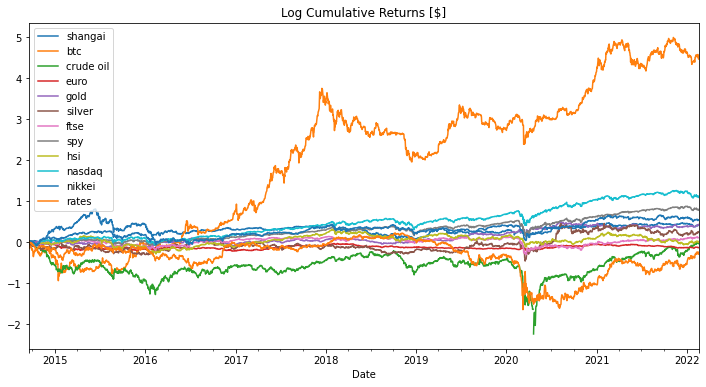

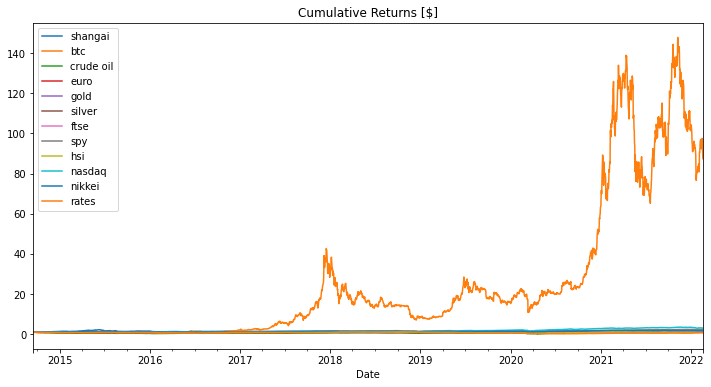

In [31]:
# For the above, it makes sense to take the logarithm
log_cumulative = np.log(cumulative)
# We can observe that log cumulative returns are reversible. This is useful for predicting price.
log_cumulative.loc[:,:].plot(
    figsize=(12,6), title='Log Cumulative Returns [$]')

np.exp(log_cumulative).plot(figsize=(12,6), title='Cumulative Returns [$]')

Here we will apply the mentioned transformation to features, in a sense que can
revert these to previous values. We will use normalization on log_cumulative (easing a lognormal step),
and normalize and standardize oscillators.

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>],
       [<AxesSubplot:title={'center':'MA80'}>,
        <AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'

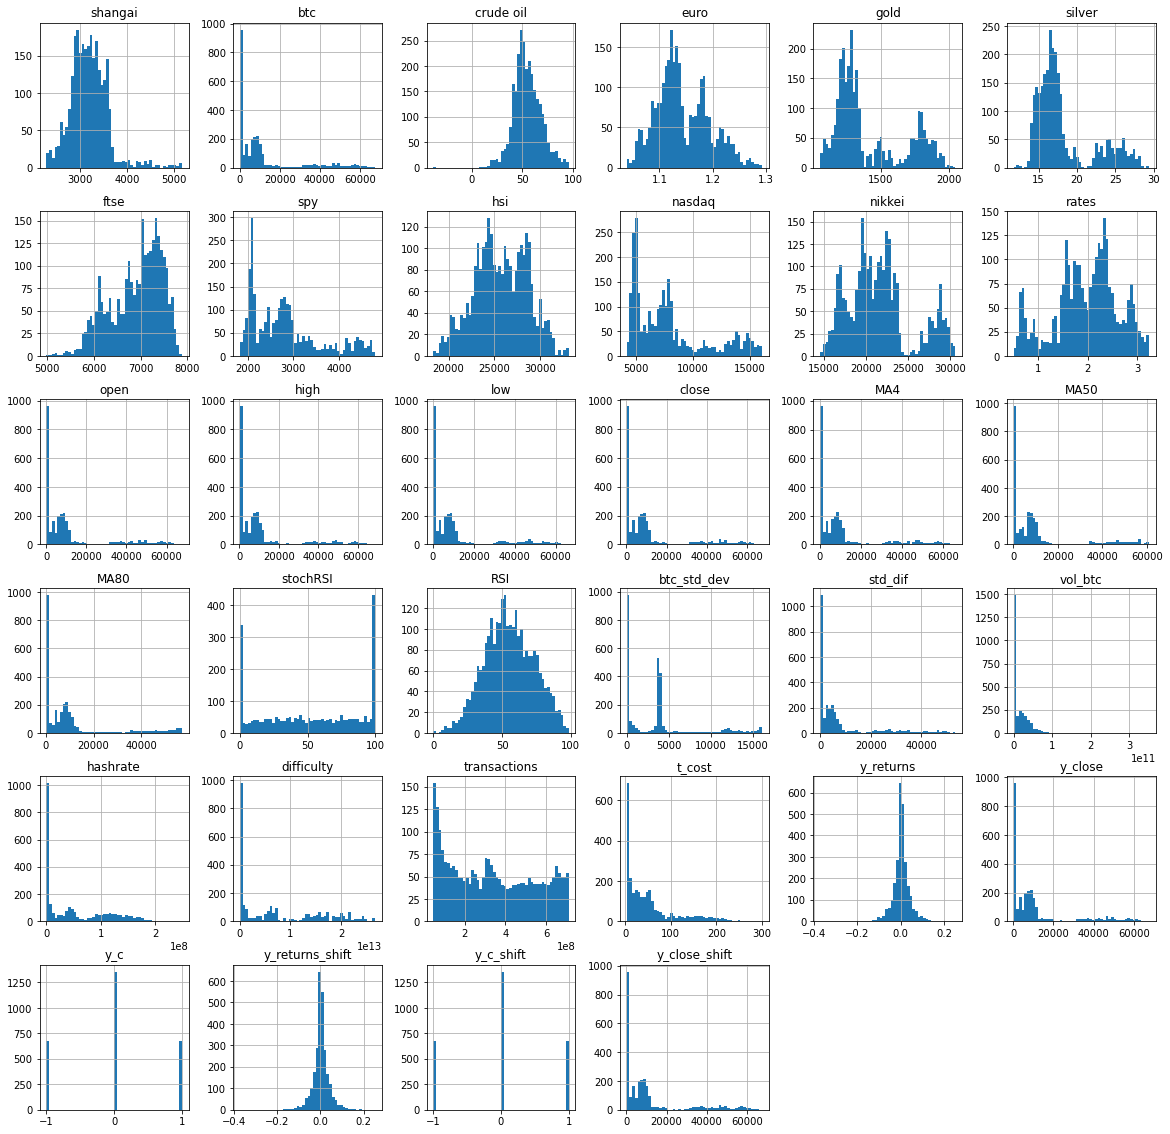

In [32]:
# Have a look at the data
df.hist(bins=50, figsize=(20,20))

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>],
       [<AxesSubplot:title={'center':'MA80'}>,
        <AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'

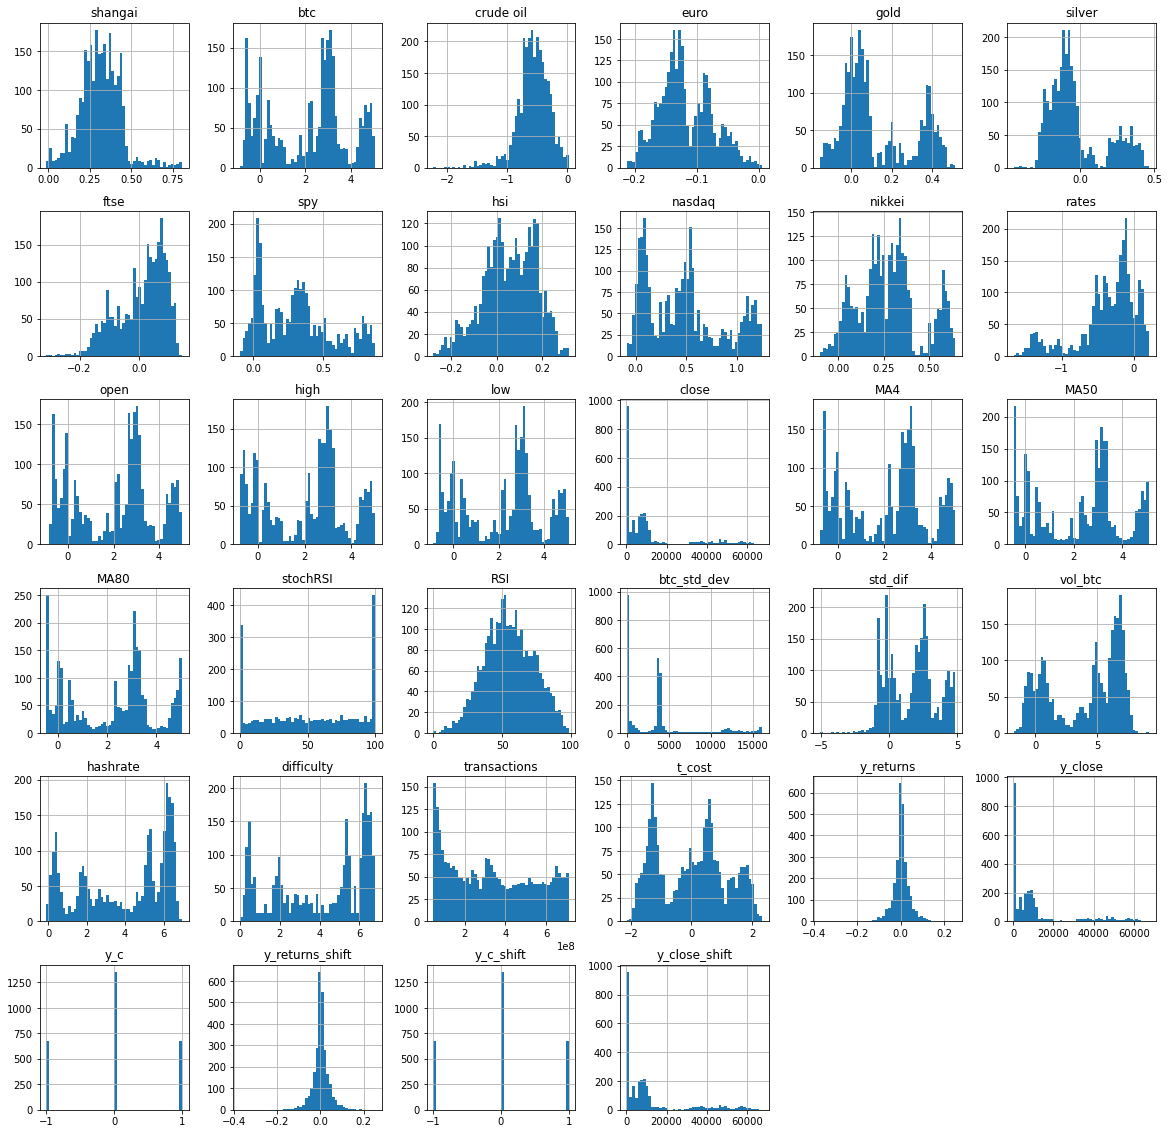

In [33]:
# Take log cumulative returns of skewed features
cum_cols = list(close.columns) + ['open', 'high','low',
            'std_dif', f'MA{ma_values[0]}', f'MA{ma_values[1]}', f'MA{ma_values[2]}',
            'hashrate', 'difficulty', 't_cost', 'vol_btc']

# We will do transformations on a copy of the dataframe to preserve original data
ndf = df
ndf[cum_cols] = (1 + ndf[cum_cols].pct_change(1)).cumprod()
ndf[cum_cols] = np.log(ndf[cum_cols])

ndf.hist(bins=50, figsize=(20,20))

In [34]:
# Drop columns that are not needed anymore
drop_cols = ['close']

for x in drop_cols:
    if x in ndf.columns:
        ndf.drop(columns=x, inplace=True)

In [35]:
# Normalize what is needed
# norm_cols = ['']
# ndf[norm_cols], mindf, maxdf = min_max_scaler(ndf[norm_cols], log=False)

['shangai', 'btc', 'crude oil', 'euro', 'gold', 'silver', 'ftse', 'spy', 'hsi', 'nasdaq', 'nikkei', 'rates', 'open', 'high', 'low', 'MA4', 'MA50', 'MA80', 'stochRSI', 'RSI', 'btc_std_dev', 'std_dif', 'vol_btc', 'hashrate', 'difficulty', 'transactions', 't_cost']


array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>,
        <AxesSubplot:title={'center':'MA80'}>],
       [<AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'}>,
        <AxesSubplot:title={'center':'btc_st

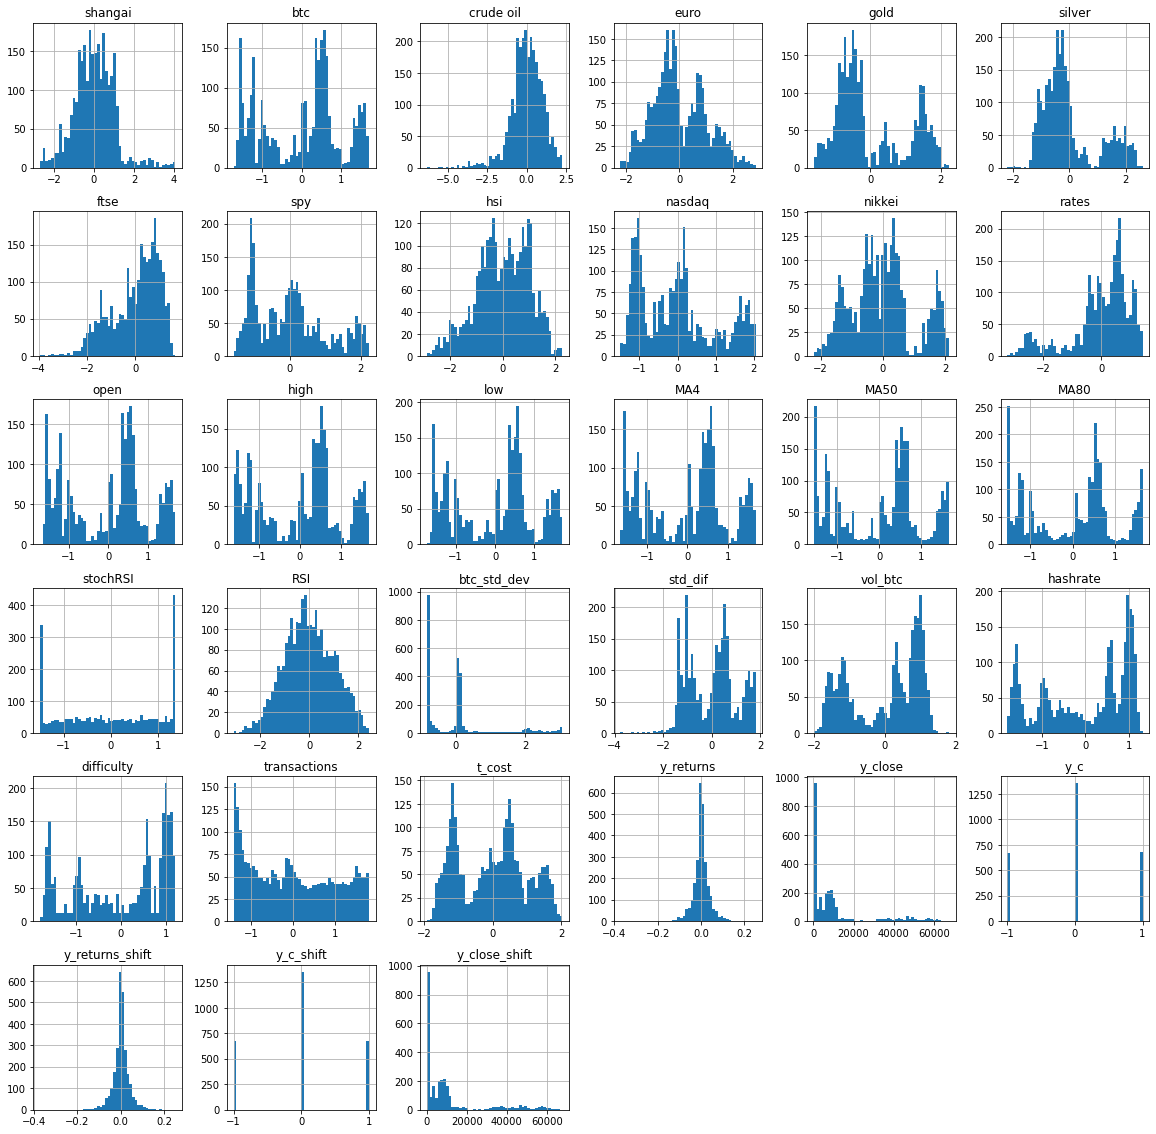

In [36]:
# Standardize what needs to be. In this case, the whole dataset, except labels
s_cols = list(ndf.columns)
non_s_cols = ['y_close', 'y_returns','y_c', 'y_c_shift', 'y_close_shift', 'y_returns_shift']

for x in non_s_cols:
    s_cols.remove(x)

print(s_cols)
ndf[s_cols], mean, std = standardizer(ndf[s_cols], log=False)

ndf.hist(bins=50, figsize=(20,20))

In [37]:
# ndf.tail()

Our features look much better now! Did not do any transformations on the labels.

## Are these features correlated?

In [38]:
# Correlation of BTC with features
cor_list = df.corr()['btc'].sort_values(ascending=False).round(2)
# cor_list.drop(
#     # index=['btc', 'open', 'high', 'low',
#     # 'std_dif', 'MA4', 'y_close_shift', 'MA50', 't_cost',
#     # 'MA80', 'transactions', 'btc_std_dev',
#     # 'RSI', 'y_returns', 'y_returns_shift', 'stochRSI', 'y_close',
#     # 'y_returns', 'y_c_shift', 'difficulty', 'hashrate']
# )
print(cor_list)

btc                1.00
low                1.00
high               1.00
MA4                1.00
open               1.00
MA50               1.00
MA80               0.99
vol_btc            0.96
hashrate           0.95
difficulty         0.95
transactions       0.94
spy                0.94
nasdaq             0.94
t_cost             0.93
std_dif            0.92
nikkei             0.88
btc_std_dev        0.83
gold               0.80
y_close_shift      0.78
y_close            0.78
silver             0.60
hsi                0.58
euro               0.38
crude oil          0.33
ftse               0.31
shangai            0.07
y_returns          0.02
RSI                0.01
y_returns_shift   -0.00
y_c               -0.00
stochRSI          -0.01
y_c_shift         -0.02
rates             -0.33
Name: btc, dtype: float64


BTC price is *negatively correlated* to FED's interest rates, and very slightly to the target variables. It also seems
uncorrelated to the RSI and the shifted returns.

On the other hand, it is **strongly correlated** to its volume, other fundamentals seen above, as well as S&P and Nasdaq.

In [39]:
# Normalized correlation does not change, uncomment below to see
# cor_list = ndf.corr()['btc'].sort_values(ascending=False).round(2)
# cor_list.drop(index=['btc', 'open', 'high', 'low',
#     'std_dif', 'MA4', 'y_close_shift', 'MA50', 't_cost',
#     'MA80', 'transactions', 'btc_std_dev',
#     'RSI', 'y_pnl', 'y_returns', 'y_returns_shift' 'stochRSI',
#     'returns_label', 'y_c_shift', 'difficulty', 'hashrate', 'log_btc_cumulative'])

<AxesSubplot:>

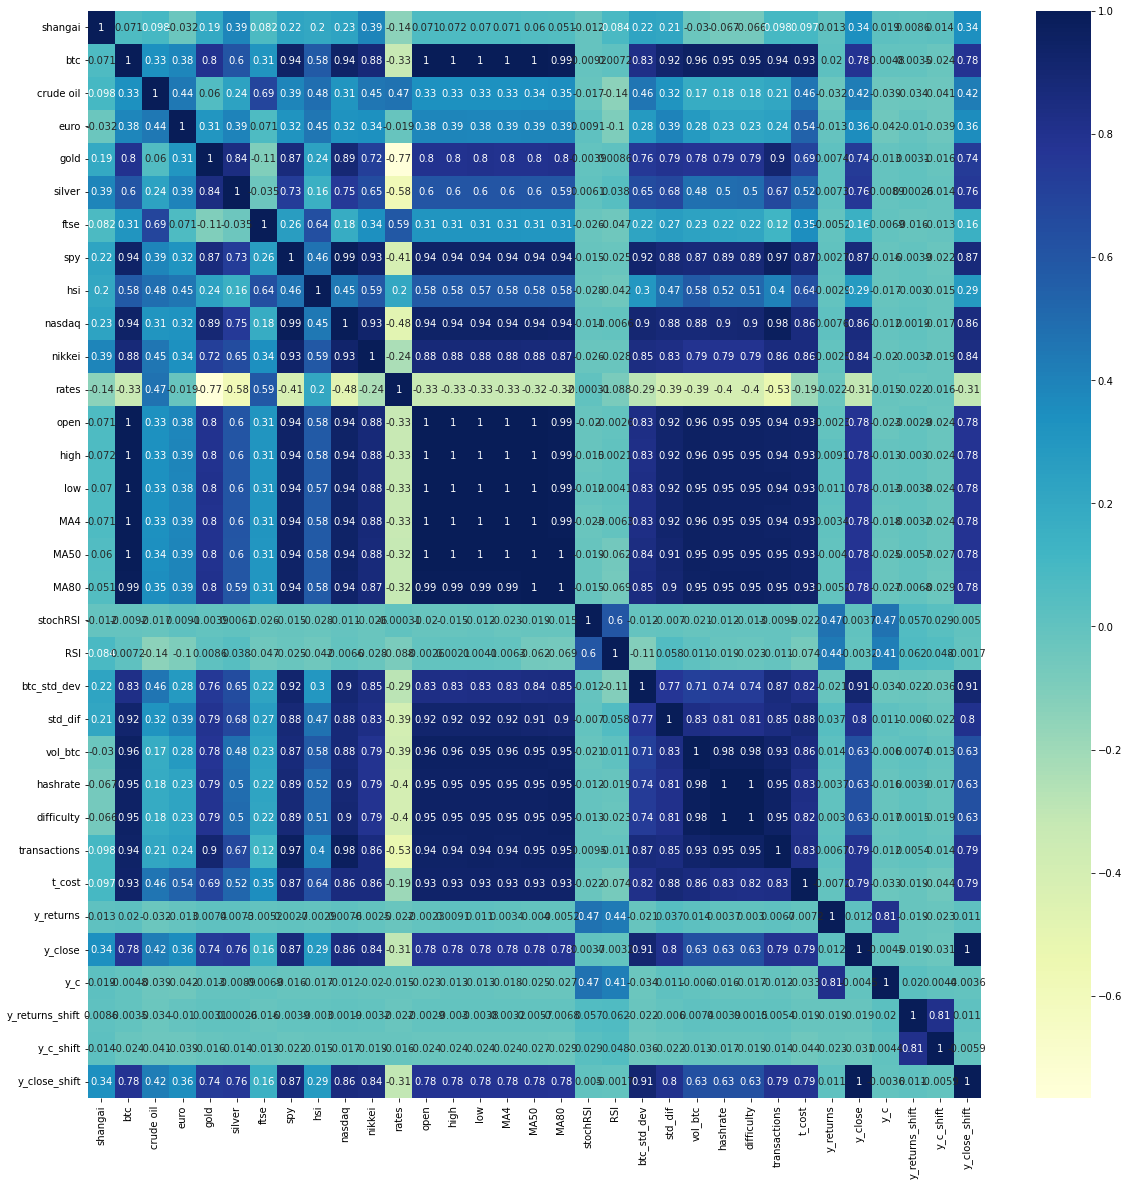

In [40]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, ax=ax,
            annot=True, 
            cmap="YlGnBu")

In [41]:
# Description of normalized features
# print(ndf.shape)
# ndf.describe()

Also interestingly, btc returns (`y_returns`) seem slightly negatively correlated with day-ahead returns.

### Saving the datasets

In [42]:
df_list = [df, ndf, mean, std]
df_path_list = ['data/df.csv', 'data/ndf.csv', 'data/mean.csv', 'data/std.csv']
for (x, y) in zip(df_list, df_path_list):
    x.to_csv(y)

# What comes next?
Ok so, we now have data we can work with! Now it's time to jump into AzureML Studio and go on with the project's
next steps:
- [**Training, tuning & deployment with AutoML**](2-automl.ipynb)
- [**Training & tuning with Hyperdrive**](3-hyperparameter_tuning.ipynb)
